In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.src.saving.saving_api import load_model

In [2]:
# define standalone discriminator
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = Input(shape=(1,))

    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)

    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)

    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # image input
    in_image = Input(shape=in_shape)

    # concat label as a channel
    merge = Concatenate()([in_image, li])

    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # flatten feature maps
    fe = Flatten()(fe)

    # dropout
    fe = Dropout(0.4)(fe)

    # output
    out_layer = Dense(1, activation='sigmoid')(fe)

    # define model
    model = Model([in_image, in_label], out_layer)

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
# define standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))

    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)

    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)

    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)

    # merge image gen and label input
    merge = Concatenate()([gen, li])

    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

    # define model
    model = Model([in_lat, in_label], out_layer)
    opt2 = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt2, metrics=['accuracy'])
    return model

In [4]:
# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model, d_model):

    d_model.trainable = False     # make weights in the discriminator not trainable
    gen_noise, gen_label = g_model.input   # get noise and label inputs from generator model
    gen_output = g_model.output     # get image output from the generator model
    gan_output = d_model([gen_output, gen_label])       # connect image output and label input from generator as inputs to discriminator
    model = Model([gen_noise, gen_label], gan_output)   # define gan model as taking noise and label and outputting a classification

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [5]:
def load_real_samples():
    (trainX, trainy), (_, _) = load_data() # load dataset
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    images, labels = dataset  # split into images and labels
    ix = randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix] # select images and labels
    y = ones((n_samples, 1)) # generate class labels
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = randn(latent_dim * n_samples)  # generate points in the latent space
    z_input = x_input.reshape(n_samples, latent_dim) # reshape into a batch of inputs for the network
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)   # generate points in latent space
    images = generator.predict([z_input, labels_input]) # predict outputs
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [6]:
def plot_losses(d_loss_list, g_loss_list):
    plt.figure(figsize=(12, 6))
    plt.plot( d_loss_list, label='Discriminator Loss', alpha=0.7)
    plt.plot( g_loss_list, label='Generator Loss', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('cGAN Training Loss')
    plt.legend()
    plt.show()

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 7ms/step
>45, 309/468, d1=0.623, d2=0.667 g=1.186
2/2 [==============================] - 0s 8ms/step
>45, 310/468, d1=0.620, d2=0.610 g=1.174
2/2 [==============================] - 0s 11ms/step
>45, 311/468, d1=0.679, d2=0.653 g=1.176
2/2 [==============================] - 0s 8ms/step
>45, 312/468, d1=0.664, d2=0.638 g=1.165
2/2 [==============================] - 0s 9ms/step
>45, 313/468, d1=0.669, d2=0.688 g=1.188
2/2 [==============================] - 0s 7ms/step
>45, 314/468, d1=0.693, d2=0.659 g=1.137
2/2 [==============================] - 0s 14ms/step
>45, 315/468, d1=0.650, d2=0.587 g=1.269
2/2 [==============================] - 0s 11ms/step
>45, 316/468, d1=0.687, d2=0.658 g=1.137
2/2 [==============================] - 0s 12ms/step
>45, 317/468, d1=0.627, d2=0.678 g=1.168
2/2 [==============================] - 0s 9ms/step
>45, 318/468, d1=0.557, d2=0.565 g=1.166
2/2 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


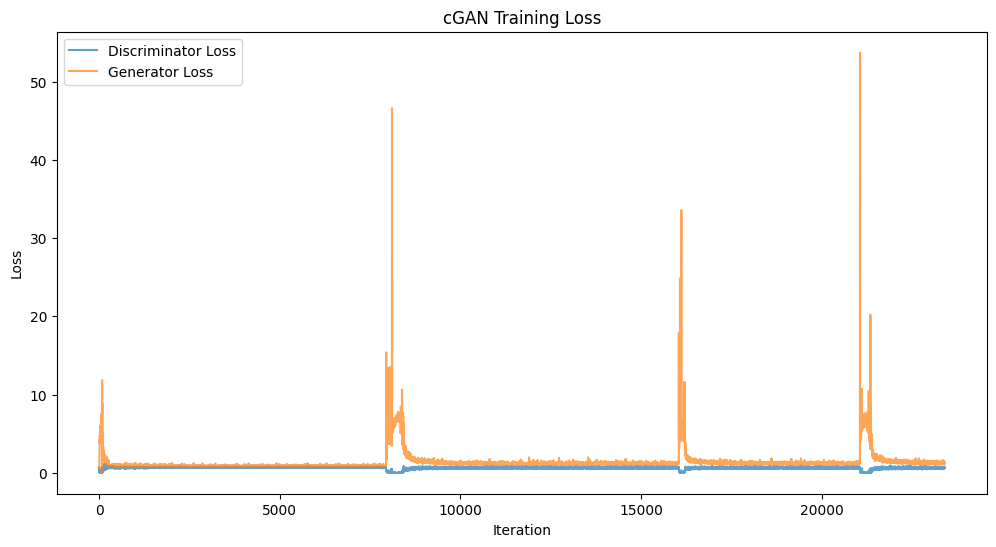

In [7]:
import matplotlib.pyplot as plt

# Initialize empty lists to store losses
d_loss_list = []
g_loss_list = []

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        # d_loss_list = []
        # g_loss_list = []
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # Append losses to lists
            d_loss_list.append(d_loss1)
            g_loss_list.append(g_loss)

            # Print loss for this batch
            print('> Epoch: %d, Count: %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))

    g_model.save('cgan_generator.h5')  # Save the generator model

    # Plot the losses
    plot_losses(d_loss_list, g_loss_list)


# Size of the latent space
latent_dim = 100
d_model = define_discriminator()  # Create the discriminator
g_model = define_generator(latent_dim)  # Create the generator
gan_model = define_gan(g_model, d_model)  # Create the GAN
dataset = load_real_samples()  # Load image data
train(g_model, d_model, gan_model, dataset, latent_dim)  # Train the model



4/4 [==============================] - 0s 39ms/step


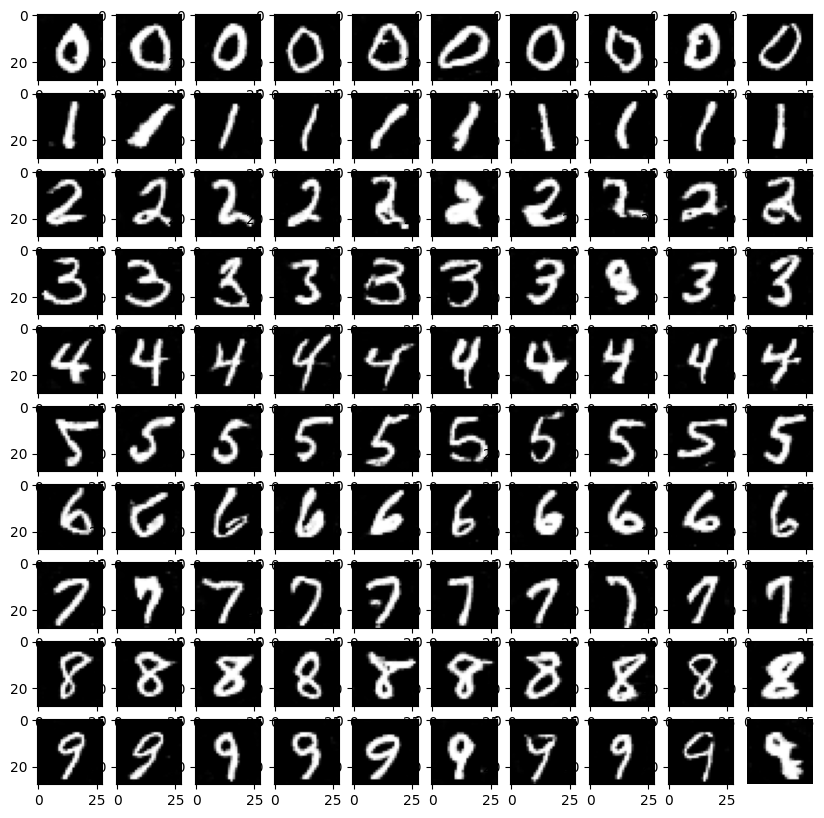

In [8]:
# Plotting the output image
def save_plot(X, n):
    num_classes = n  # Assuming there are n classes
    num_samples = len(X) // num_classes  # Assuming an equal number of samples per class

    fig, axes = plt.subplots(num_samples, num_classes, figsize=(num_classes, num_samples))

    for class_label in range(num_classes):
        for i in range(num_samples):
            plt.axis('off')
            image_index = class_label * num_samples + i
            axes[i, class_label].imshow(X[image_index, :, :, 0], cmap='gray')

    plt.show()


# Model usage
model = load_model('cgan_generator.h5')
latent_dim = 100
n = 10  # Number of classes
num_samples = 10  # Number of samples per class
[inputs, labels] = generate_latent_points(latent_dim, n * num_samples)
labels = np.asarray([x for _ in range(num_samples) for x in range(n)])
X = model.predict([inputs, labels])
save_plot(X, n)

